# To do:
Fix font size of pandas tables in reveal.js presentation

Increase font size for Markdown table in presentation (code in notebook does not transfer to html)

Increase graph size for plots 

Talk more concretely about bias in culture section: bias is everywhere and hard to measure

Put in a DAG at start of regression or some explanation of how we use regression to avoid bias: causal inference is hard, and this helps to explain

Talk about p-value rather than t-stats

Don't say PPG coefficient is small

Say weighted least squares in regression part

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)

# Measuring bias in social media

## A sentiment analysis of NBA and NFL reddit

### Powerpoint slide of Cedi and Tristan

## Outline

I. Getting the data: scraping reddit

II. Quantifying the data: calculating sentiment

III. Understanding the data: Using regression to understand what makes athletes popular

IV. Results!

## 0. Sports allow us to understand social media in a highly quantitative way

#### Sports allow us to measure performance far more accurately than other parts of culture

#### Social media is often where ideas incubate

## I. Getting the data: scraping reddit

(Aside: getting historical data from Twitter was not obvious)

### Scraping using reddit's API

#### Reddit's API is quite good

Allows you to post comments, reply, and act like a user

#### Disadvantages

It's designed around acting like a user rather than scraping

It requires authentication

It broke a month after I started

## Scraping using the pushshift API

[pushshift.io](https://pushshift.io/api-parameters/) is a third party social media data aggregator, specializing in reddit

### Advantages

No authentication

Did not change API while I used

Easy to use

### Example query to pushshift
As simple as parsing a `requests` query

In [2]:
import requests
import simplejson as json
url_params = {'subreddit': 'nba',
              'size':500}
submission_url = 'https://api.pushshift.io/reddit/search/submission/'
pushshift_response = json.loads(requests.get(submission_url, params=url_params).text)

In [5]:
pushshift_response['data'][0]

{'author': 'deadskin',
 'author_flair_background_color': '',
 'author_flair_css_class': 'Raptors2',
 'author_flair_richtext': [],
 'author_flair_text': '[TOR] Jose Calderon',
 'author_flair_text_color': 'dark',
 'author_flair_type': 'text',
 'author_fullname': 't2_5nr6h',
 'author_patreon_flair': False,
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1554215998,
 'domain': 'streamable.com',
 'full_link': 'https://www.reddit.com/r/nba/comments/b8k2m6/brook_lopez_turned_31_yesterday_and_received_a/',
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'id': 'b8k2m6',
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': False,
 'is_video': False,
 'link_flair_background_color': '',
 'link_flair_css_class': 'highlights',
 'link_flair_richtext': [],
 'link_flair_text': 'Highlights',
 'link_flair_text_color': 'dark',
 'link_flair_type': 'text',
 'locked': False,
 'media': {'oemb

#### Parse the JSON into a DataFrame

In [11]:
sample_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv', nrows=100, sep='\t')
sample_df.head(3)[['user', 'flair', 'year_month', 'sentences']]

,user,flair,year_month,sentences
0,nymusix,Warriors,201710,jokic with an absolutely beautiful dime [highlight].
1,Hustle_Marsalis,Pelicans,201710,also espn and si ranking player like jokic ahead of him.
2,21sewage,Nuggets,201710,[wind] jokic on westbrook’s shoulder check: “i flopped.”.


#### Get other performance data from a variety of websites

In [9]:
user_player_df = (pd.read_csv('c:/Users/map22/Google Drive/sentiment_nba/nba_user_player_sentiment.tsv', sep='\t')
                    .rename(columns={'compound_mean':'mean_sentiment'}))
user_player_df[['Player', 'season', 'salary', 'PPG', 'MP', 'ThreePP', 'TRB', 'PER']].sample(3)

,Player,season,salary,PPG,MP,ThreePP,TRB,PER
1015006,zaza pachulia,2015,5200000.0,8.6,2004.0,0.000,9.4,16.2
731209,matthew dellavedova,2017,9607500.0,4.3,712.0,0.372,1.7,8.6
797884,paul george,2013,3282003.0,21.7,2898.0,0.364,6.8,20.1


## II. Calculate sentiment towards players
### Part I: Figure out which players the comments are about
### Part II. Quantify sentiment towards the player

### Named entity recognition (NER): identifying named entities in text

#### Approach 1: Use Named entity recognition to identify players
Stanford has a nice NER package I recommend


Models go about this different ways. Some try to classify each token, with properties about the token (capitalization, place in sentence). Others like CRF use contextual cues from other words. There are even deep neural nets for this. I used Stanford's off the shelf NER.

In [16]:
from sner import Ner
pos_tagger = Ner(host='localhost',port=9199)
pos_tagger.get_entities('Isaiah Thomas is the worst.' )

[('Isaiah', 'PERSON'),
 ('Thoms', 'PERSON'),
 ('is', 'O'),
 ('the', 'O'),
 ('worst.', 'O')]

#### Doesn't always work

In [21]:
pos_tagger.get_entities('Cedi is the GOAT!' )

[('Cedi', 'O'), ('is', 'O'), ('the', 'O'), ('GOAT!', 'O')]

#### Approach 2: Use a known list of players

We already know the players we care about, so let's extract those.
Have both upper and lower case player names. Example data

In [36]:
# Use a set for fast lookup
PLAYER_SET = {'cedi', 'love', 'cavs', 'lebron'}
toy_df = pd.DataFrame({'comment':['Cedi is the GOAT',
                                  'LeBron told Love to fit in, not fit out']})


#### Find string matches for names

In [37]:
toy_df['comment'] = toy_df['comment'].str.lower()

# tokenize sentence with split, and use filter to find named entities
ner_filter = lambda sentence: [word for word in sentence.split() if word in PLAYER_SET]
toy_df['lower_entities'] = toy_df['comment'].apply(ner_filter)
toy_df

,comment,lower_entities
0,cedi is the goat,[cedi]
1,"lebron told love to fit in, not fit out","[lebron, love]"


### Evaluating unknown and known NER approaches

I hand labeled ~50 random sentences from my dataset for the named entities, and calculated precision and recall within this dataset.

|NER Model |Precision|Recall|
|---|---|---|
|Stanford| 87  | 46  |
|Regex  | 99  | 88  |

### Doing string matching for known entities outperforms NER

NER is useful when new entities are emerging constantly (news)

## Part 2: Calculating sentiment

#### Sentiment: positive or negative feelings



Generally, or towards a particular subject

#### Entity-sentiment models tie sentiment in a sentence directly to entities

LeBron is better than Jordan

In above sentence, entity-sentiment model could detect that LeBron gets high sentiment, and Jordan gets low sentiment.

#### These models are slow

### Sentence-level sentiment models

#### 1. Filter out sentences with more than one entity

#### 2. Calculate sentiment for these sentences using VADER

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.lexicon['steal']

-2.2

#### Update VADER labels for basketball

In [ ]:
stat_words = ['steal', 'steals', 'block']
sid.lexicon.update({word:0.0 for word in stat_words})

#### VADER outputs combined sentiment score for sentences

In [5]:
sid.polarity_scores('Cedi is the best!')

{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}

### Explore sentiment data

#### Aggregate data at level of (user, player, year)

In [23]:
user_player_df[['user', 'Player', 'season', 'comment_count', 'mean_sentiment']].sample(3)

,user,Player,season,comment_count,mean_sentiment
4266,dipset4444,al horford,2016,1,0.0000
9767,TheMagnet69,alexey shved,2017,1,0.0000
5149,redsnake1377,al horford,2016,9,0.0475


#### Most people comment rarely
#### Sentiment is skewed positive

Text(0.5,0,'Mean sentiment towards player')

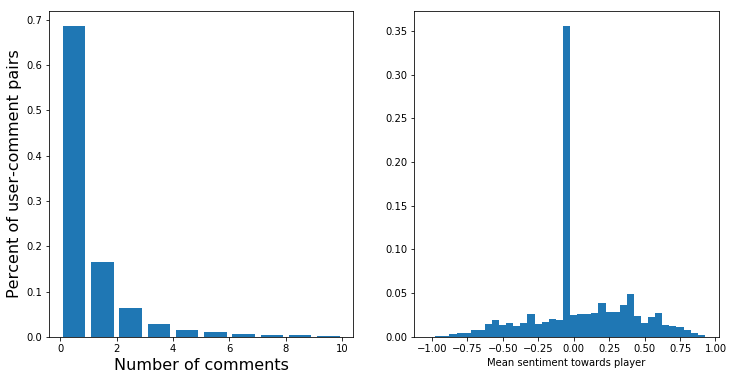

In [60]:
fs = 16
fig, [ax1, ax2] = plt.subplots(1,2, figsize =[12,6])
ax1.bar(np.arange(0.5, 10.5, 1),user_player_df.comment_count.value_counts().head(10)/ user_player_df.shape[0]);
ax1.set_ylabel('Percent of user-comment pairs',fontsize =fs)
ax1.set_xlabel('Number of comments', fontsize =fs)
sentiment_hist, sentiment_bins = np.histogram(user_player_df['mean_sentiment'], bins = np.arange(-1, 1, 0.05))
sentiment_hist = sentiment_hist / sentiment_hist.sum()
ax2.bar(sentiment_bins[:-1], sentiment_hist, 0.05)
ax2.set_xlabel('Mean sentiment towards player', fontsize=fs)

#### No clear difference between white and black players

Standard deviation of sentiment for high comment players: 0.052963271203892465


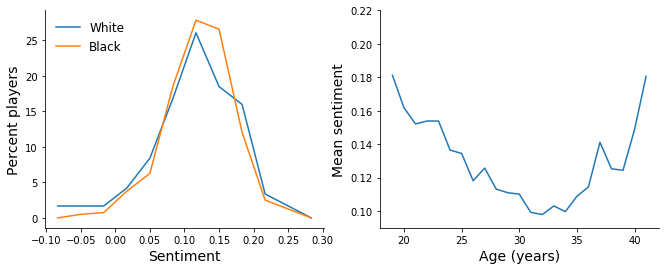

In [38]:
Where code for plotting would be
print('Standard deviation of sentiment for high comment players: ' + str(graph_df['mean_sentiment'].std()))

## III. Using regression to understand factors

#### In machine learning, often care about predictive performance of model

Coefficient sizes and significance is interesting for explainability, but not essential

#### In economics or social science research, magnitude and significance of coefficients is most important

Predictive performance is less so

#### Reminder of what data looks like

In [25]:
user_player_df[['user', 'Player',  'season',  'mean_sentiment', 'PPG', 'MP', 'TRB']].sample(2)

,user,Player,season,mean_sentiment,PPG,MP,TRB
4863,mayence,al horford,2017,0.000000,12.9,2277.0,7.4
9569,sargo13,alex len,2017,-0.251067,8.5,1395.0,7.5


### Simple model: two covariates

In [4]:
model = smf.wls( formula = 'compound_mean ~ MP + PPG',
                 data = nba_df,
                 weights = 1).fit()

In [4]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           1.10e-45
Time:                        20:36:54   Log-Likelihood:            -2.6926e+05
No. Observations:              848401   AIC:                         5.385e+05
Df Residuals:                  848398   BIC:                         5.386e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0700      0.001     73.923      0.000       0.068       0.072
MP         -1.125e-06   6.52e-07     -1.726      0.084    -2.4e-06    1.53e-07
PPG            0.0007   6.46e-05     11.124      0.000       0.001       0.001
==============================================================================
Omnibus:                     1033.683   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.941
Skew:                          -0.044   Prob(JB):                    3.60e-252
Kurtosis:                       3.159   Cond. No.                     5.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Full model

In [8]:
user_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP + TOVP' \
                           ' + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = 1 
               ).fit()

In [9]:
user_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     55.70
Date:                Mon, 01 Apr 2019   Prob (F-statistic):          2.62e-245
Time:                        20:00:32   Log-Likelihood:            -2.3957e+05
No. Observations:              758575   AIC:                         4.792e+05
Df Residuals:                  758552   BIC:                         4.795e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0866      0.004     22.578      0.000       0.079       0.094
C(height_dummies)[T.short]      0.0061      0.002      2.824      0.005       0.002       0.010
C(height_dummies)[T.tall]     4.16e-05      0.001      0.037      0.970      -0.002       0.002
rookie[T.True]                  0.0205      0.002     12.878      0.000       0.017       0.024
team_match[T.True]              0.0042      0.001      4.521      0.000       0.002       0.006
C(Race)[T.W]                    0.0072      0.002      4.792      0.000       0.004       0.010
MP                          -4.747e-06   1.04e-06     -4.581      0.000   -6.78e-06   -2.72e-06
ThreePP                         0.0080      0.004      2.225      0.026       0.001       0.015
DWS                             0.0017      0.001      2.551      0.011       0.000       0.003
TRBP                           -0.0005      0.000     -3.312      0.001      -0.001      -0.000
FTr                            -0.0132      0.003     -4.293      0.000      -0.019      -0.007
ASTP                           -0.0002   5.72e-05     -3.206      0.001      -0.000   -7.13e-05
BLKP                            0.0008      0.000      2.116      0.034    5.65e-05       0.001
STLP                            0.0021      0.001      3.172      0.002       0.001       0.003
TOVP                           -0.0003      0.000     -2.386      0.017      -0.001   -5.01e-05
youth                           0.0023      0.000      8.922      0.000       0.002       0.003
oldness                         0.0012      0.000      7.159      0.000       0.001       0.002
Wins                        -6.033e-05   3.87e-05     -1.558      0.119      -0.000    1.56e-05
demean_clinton                  0.0077      0.003      3.043      0.002       0.003       0.013
C(Race)[T.W]:demean_clinton    -0.0022      0.005     -0.416      0.678      -0.013       0.008
total_population            -1.179e-10   9.45e-11     -1.248      0.212   -3.03e-10    6.73e-11
demean_PPG                      0.0013      0.000     12.670      0.000       0.001       0.001
C(Race)[T.W]:demean_PPG         0.0014      0.000      7.107      0.000       0.001       0.002
==============================================================================
Omnibus:                      936.893   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1054.433
Skew:                          -0.043   Prob(JB):                    1.08e-229
Kurtosis:                       3.162   Cond. No.                     1.10e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

### Details of weighting and clustered standard errors on github

## IV: Results!
### NBA Players

### Lowest and highest sentiment seasons

|Player |Year    | Avg Sentiment  | Player  | Year  | Avg Sentiment|
|--- |--- |---|---|---|---|
| Mike Dunleavy  | 2016  | -0.11  | Brandon Ingram  | 2015  |0.27 |
| Kelly Olynyk  | 2016  | -0.08  | Karl-Anthony Towns  | 2015  |0.26 |
| Steve Blake  | 2015  | -0.07  | Marc Gasol  | 2014  |0.25 |
| Zaza Pachulia  | 2017| -0.07  | Gordon Hayward  | 2014 |0.24|


### PPG is significant for sentiment

| Coefficient | (1) |
|:--|--| 
| PPG| 0.0007 (1.985) | 

### Coefficients for age are significant

| Coefficient | (1) | (2) |
|:--|--| -- |
| PPG| 0.0007 (1.985) | 0.0012 (2.3) |
|Rookie| - |  0.02 (5.4)|
|1 year of youth (<27)| - | 0.0028 (3.6) |
|1 year of age (>27)  | - | 0.0014 (2.0) |
|Race| - | 0.0004 (1.76) |  

### Coefficients for race interacted with scoring is significant

| Coefficient | (1) | (2) | (3)|
|:--|--| -- | -- |
| PPG| 0.0007 (1.985) | 0.0012 (2.3) | 0.001 (2.2)|
|Rookie| - |  0.02 (5.4)| 0.022 (4.8)|
|1 year of youth (<27)| - | 0.0028 (3.6) | 0.0026 (3.2) |
|1 year of age (>27)  | - | 0.0014 (2.0) | 0.008 (1.6) |
|Race| - | 0.0004 (1.76) |  0.008 (1.6)|
|PPG for white player| - | -  |  0.0016 (2.6) |
|Commenter City (Democratic vote)| - | -  |  0.0096 (3.2) |


### We may be missing important variables
* Twitter / social media by player
* Shoe endorsements
* Physical attractiveness

### Coaches

#### Highest and lower sentiment seasons


|Coach|Year    | Avg Sentiment  | Player  | Year  | Avg Sentiment
|---|---|---|---|---|---|
| Brad Stevens  | 2014-2015| 0.3  | George Karl  | 2015-2016|-0.15 |
| Erik Spoelstra  | 2014-2015  | 0.26  | Earl Watson  | 2017-2018|-0.1 |
| Brad Stevens  | 2017-2018| 0.24  | Kurt Rambis  | 2015-2016|-0.1 |
| Steve Kerr  | 2014-2015| 0.23  | Fred Hoiberg  | 2015-2016|-0.06|


### Regression results


|Coefficient|Magnitude (t-statistic)|
|--|--|
|Season Wins|-0.08 (-1.5)|
| Win % over expectation | 0.39 (4.5) | 
|Career Win %|0.39 (4.5)|
|Age (years)| (-0.0033 (-2.7)|
|Tenure with team (years)| 0.0048 (2.2)|
|Race (white)|0.047 (2.8)|


#### Being white is worth ~ +10 wins

## NFL Players

### Unique difficulties of NFL

#### There are 3-4x more players

#### Fewer players have easily comparable stats

Two parts: Defense and offense are hard to compare, so we focus on offense

Only a fraction of offensive players even have stats! Around 5-6 per team compared to 10ish in NBA

### Lowest and highest sentiment seasons

|Player |Year    | Avg Sentiment  | Player  | Year  | Avg Sentiment|
|--- |--- |---|---|---|---|
| Gregg Williams  | 2017  | -0.29  | Sean McVay   | 2017  |0.28 |
| Michael Bennett  | 2017  | -0.25  | David Johnson  | 2016  |0.24 |
| Gregg Williams  | 2016  | -0.23  | JJ Watt  | 2017  |0.22 |
| Danny Trevathan  | 2015| -0.15  | JJ Watt  | 2016 |0.22|

### NFL Player regression results

#### Performance alone is significant
z_DVOA = z-score Yards over average

| Coefficient | (1) |
|:--|--| 
| z_DVOA| 0.0057 (2.1) | 

### In full regression, only rookie status is significant

| Coefficient | (1) | (2) |
|:--|--| -- |
| z_DVOA| 0.0057 (2.1) | 0.0051 (1.4) |
|Rookie| - |  0.018 (2.4)|
|1 year of youth (<27)| - | 0.0011 (0.7) |
|Race (white)| - | 0.0067 (1.2) |  
|City population  | - | -4e10 (-2.4) |

## NFL Coaches

### Coaches

#### There are not many black coaches to analyze

In [41]:
coaches_fit_df.groupby('race').agg(['mean', 'count'])['compound_mean_mean']

,mean,count
race,,
B,0.050933,24
W,0.071046,130


#### Highest and lower sentiment seasons


|Coach|Year    | Avg Sentiment  | Player  | Year  | Avg Sentiment
|---|---|---|---|---|---|
| Sean McVay  | 2017| 0.28  | Sean Payton  | 2015-2016|-0.11 |
| Adam Gase  | 2016  | 0.27  | Mike Smith  | 2013|-0.08 |
| Todd Bowles  | 2015| 0.27  | John Fox  | 2014|-0.08 |
| TBD  | 2014-2015| 0.23  | Ron Rivera  | 2015|-0.07|


### Regression results
(Not correct)


|Coefficient|Magnitude (t-statistic)|
|--|--|
|Season Wins|-0.08 (-1.5)|
| Win % over expectation | 0.39 (4.5) | 
|Career Win %|0.39 (4.5)|
|Age (years)| (-0.0033 (-2.7)|
|Tenure with team (years)| 0.0048 (2.2)|
|Race (white)|0.047 (2.8)|


# Conclusion

### If you already know what your entities are, regex for them can work well

### In economics / social sciences, regression coefficients are important

### Reddit likes young, high scoring players, particularly if they're white

### Reddit penalizes black coaches approximately 10 wins of affection

### No evidence of bias in NFL

# Links

#### Github: github.com/map222/, `trailofpapers` repo
#### Blog: trailofpapers.net
#### Twitter: @trailofpapers
#### E-mail: map222@gmail.com

## Appendix

#### Variance of sentiment goes down as comment count goes up

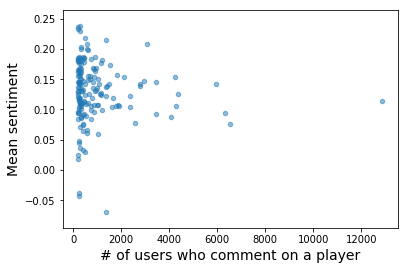

In [32]:
Graphing code goes here

### How do we weight?

In [ ]:
user_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP + TOVP' \
                           ' + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = 1 
               ).fit()

#### Weight each user-player pair the same

#### Weight by comment count

#### Weight by sqrt(comment count)

### Changing weighting does not significantly change the coefficients or t-stats

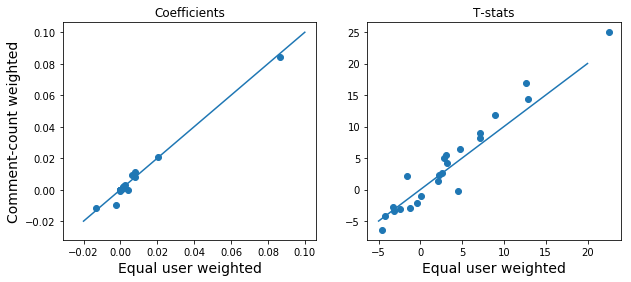

In [19]:
Where code to plot this would go

### Clustered standard errors allows us to recognize that players are commented on by multiple users

In [51]:
clustered_model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP' \
                           '+ TOVP  + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',
                data = nba_df,
               weights = np.sqrt(nba_df['comment_count'])
               ).fit(cov_type='cluster', cov_kwds={'groups' : nba_df['Player']})

### Clustering standard erorrs does not change coefficients, but decreases t-statistics

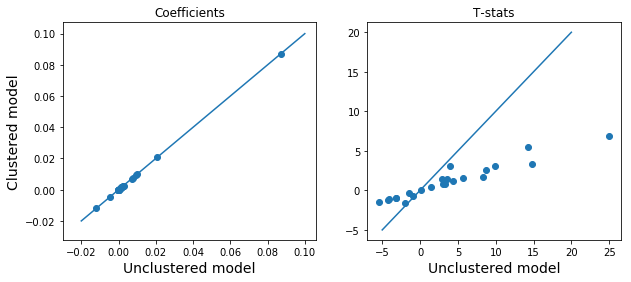

In [61]:
Where plotting code would go